# 소프트맥스 회귀로 MNIST 데이터 분류하기

MINIST 데이터는 0부터 9로 되어 있는 손글씨 데이터 셋입니다.

총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 훈련 데이터와 레이블로 구성되어있습니다.

MINIST는 28x28의 2차원 이미지로 총 784개의 픽셀로 되어 있다.

어떤 이미지가 무슨 숫자인지 맞추는 것이 목표이다.

In [1]:
import torch
# torchvision은 유명한 데이터셋들, 이미 구현되어 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지 입니다.
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


CPU로 학습할지 GPU로 학습할지 결정하는 코드

원래 CPU가 컴퓨터가하는 모든 일을 조종/통제해왔지만, 점차 기술이 발전하면서 GUI등 다양한 일을 CPU가 모두 해야만 했다.

그래서 간단한 연산들(ex.그래픽작업) 등을 처리해줄 수 있는 별도의 Processing unit을 만들게 되었고 그것이 GPU이다.

따라서 CPU는 어려운 문제를 푸는 싱클 코어로 특화되었고, GPU는 쉬운 문제를 동시에 푸는데 특화된 멀티코어로 발전하였다.

따라서 CPU는 직렬연산이고, GPU는 병렬연산으로 되어 있다.

원래 GPU가 하던 연산이 벡터나 행렬 연산이였기 때문에 병렬성으로 극대화된 GPU의 연산이 딥러닝 연산에 최적화 되어 있는 것이다.

In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# hyperparameters
training_epochs = 15
batch_size = 100

Seed를 고정히키고 epochs와 batch_size를 100으로 고정시켰다.

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw




Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw




Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw




Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



MNIST 데이터들을 다운 받아주었다.

In [5]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

이제 다운 받은 데이터들을 Load할 것이다. 

첫번째 인자: dataset은 로드할 대상을 의미하며

두번째 인자: batch_size는 배치 크기

shuffle: 매 에포크마다 미니 배치를 셔플할 것인지의 여부

drop_last: 마지막 배치를 버릴 것인지를 의미

마지막 배치를 버리는 이유는 총 data 크기를 딱 맞게 나누지 않는 이상 나머지 값들이 남게 되기 때문이다.

In [6]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

nn.Linear를 이용하여 모델을 설정한다.

이때 Input은 28 x 28인 784이고 Output은 0~9까지 10개이다.

In [7]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

Cost Function은 CrossEntropy를 사용하고, Optimizer는 SGD를 사용한다.

In [8]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad() #gradient 초기화
        hypothesis = linear(X) #Hypothesis에 train data 넣기
        cost = criterion(hypothesis, Y) #Cost 값구하기
        cost.backward() # Cost를 이용해 gradient 계산
        optimizer.step() # W와 b 업데이트

        avg_cost += cost / total_batch # 평균 Cost 구하기

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577715
Epoch: 0003 cost = 0.331264257
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956169
Epoch: 0009 cost = 0.287074119
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422735
Learning finished


Accuracy: 0.8883000016212463
Label:  7
Prediction:  7


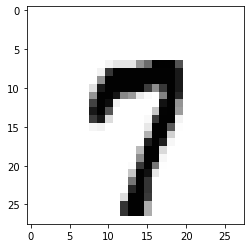

In [12]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device) #data를 1차원 벡터로 변환하고 float값으로 바꾸어준다
    Y_test = mnist_test.test_labels.to(device) #data의 label

    prediction = linear(X_test) #X_test를 이용하여 예측
    correct_prediction = torch.argmax(prediction, 1) == Y_test #가장 확률이 높은 것을 1로한 다음에 Label과 정답 비교
    accuracy = correct_prediction.float().mean() # 정답 여부를 float 값으로 평균내어 accuracy 계산
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    # data 시각화
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()